# Uso de la API de Banxico para Descargar el Histórico de Tipos de Cambio

@Antonio Rendon 2023

# Introducción:

El Banco de México (Banxico) provee un acceso programático a diversas series de datos económicos, incluyendo el histórico de tipos de cambio, a través de su Sistema de Información Económica (SIE). Esta herramienta es esencial para quienes buscan analizar tendencias y hacer proyecciones basadas en la evolución del valor del peso mexicano. En este Jupyter Notebook, te guiaré por el proceso de cómo usar la API de Banxico para obtener y visualizar estos datos.

## Importando librerias necesarias

###  __requests__ es una biblioteca Python esencial para realizar solicitudes HTTP. Al trabajar con la API de Banxico:

* Simplicidad: Permite hacer peticiones a la API con pocas líneas de código.
* Manejo de parámetros: Facilita el envío de parámetros para personalizar las consultas.
* Procesamiento de Respuestas: Convierte fácilmente las respuestas del servidor, como JSON, en estructuras de datos de Python.


###  __pandas__ usaremos esta biblioteca para manejar los datos en un Data Frame


In [59]:
import requests
import pandas as pd


Siguiendo la documentacion de la API que encontramos en  https://www.banxico.org.mx/SieAPIRest/service/v1/doc/consultaDatosSerieRango , vamos a definir los parametros de nuestra consulta

In [60]:
# Definiendo los parametros para la consulta

#base_url = "https://www.banxico.org.mx/SieAPIRest/service/v1/series/{idSerie}/datos/{fechaIni}/{fechaFin}/"
base_url = "https://www.banxico.org.mx/SieAPIRest/service/v1/series/{idSerie}/datos/{fechaIni}/{fechaFin}?token={token}"


params = {
    "idSerie": "SF343410",     # Esta serie se refiere al Tipo de Cambio Cierre de Jornada
    "fechaIni": "2023-01-01",  # Definimos la fecha de inicio de nuestra consulta
    "fechaFin": "2023-09-15",  # Fecha final de nuestra consulta
    "token": "ee0b619352ac0a9fcd2fafe7c979340e52cce0cb692ecc46ca92bf305855c227"  #este es un token de consulta que generamos desde la pagina de Banxico
}



 La función __format()__ se utiliza para sustituir los lugares reservados en base_url con los valores correspondientes del diccionario params.

 El operador __**__ desempaqueta el diccionario, pasando sus claves y valores como argumentos con nombre a la función format().

  __base_url__ es una cadena de texto que contiene lugares reservados (placeholders) denotados por llaves {}. Estos lugares reservados están destinados a ser reemplazados por valores reales.

  Con esto formamos la URL completa que usaremos para solicitar información

In [61]:
# Formatear la URL con los valores específicos para idSerie, fechaIni y fechaFin.
url = base_url.format(**params)


La línea __response = requests.get(url)__ utiliza la biblioteca requests para realizar una solicitud HTTP GET a la URL especificada.

Una vez que la solicitud se ha completado, response contendrá varios atributos y métodos que te permiten acceder y manipular la respuesta. Por ejemplo, response.status_code te dará el código de estado HTTP de la respuesta (como 200 para OK, 404 para No Encontrado, etc.), y response.text te dará el contenido de la respuesta como una cadena.

In [62]:

# Realizar la solicitud GET a la URL especificada con los parámetros dados.
response = requests.get(url)


Por ultimo verificamos si el codigo de respuesta es __200__ lo cual nos indicaria una respuesta exitosa y en caso contrario mostramos el error.

Si la respuesta fue exitosa, solo resta convertir el JSON en un dataframe

In [63]:
# Verificar si la respuesta es exitosa (código HTTP 200).
if response.status_code == 200:
    # Convertir la respuesta (que es un string de JSON) en una estructura de datos de Python.
    data = response.json()

    # Convertir la parte relevante del JSON (basado en su estructura) en un DataFrame de pandas.
    historico = pd.DataFrame(data['bmx']['series'][0]['datos'])

    # Mostrar el DataFrame.
    print(historico)
else:
    # Si la respuesta no es exitosa, mostrar un mensaje de error.
    print(f"Error: {response.status_code} - {response.text}")

          fecha     dato
0    02/01/2023  19.4753
1    03/01/2023  19.3861
2    04/01/2023  19.3985
3    05/01/2023  19.3298
4    06/01/2023  19.1580
..          ...      ...
175  11/09/2023  17.3058
176  12/09/2023  17.2493
177  13/09/2023  17.1494
178  14/09/2023  17.1150
179  15/09/2023  17.0723

[180 rows x 2 columns]


Ahora solo resta convertir nuestros datos al tipo apropiado para tener completo nuestro historico de tipos de cambio proprocionados por Banxico

In [64]:
historico['fecha'] = pd.to_datetime(historico['fecha'], format='%d/%m/%Y')
historico['dato'] = pd.to_numeric(historico['dato'])
historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   180 non-null    datetime64[ns]
 1   dato    180 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.9 KB


Solo queda aprovechar nuestro histórico de datos. Aunque es posible almacenarlos para análisis posteriores en herramientas como Tableau, en esta ocasión nos centraremos en visualizar la fluctuación del tipo de cambio peso-dólar usando matplotlib. Para brindar un contexto más claro, incorporaremos una línea que señale la media y otra que destaque la barrera psicológica de los 18 pesos por dólar.

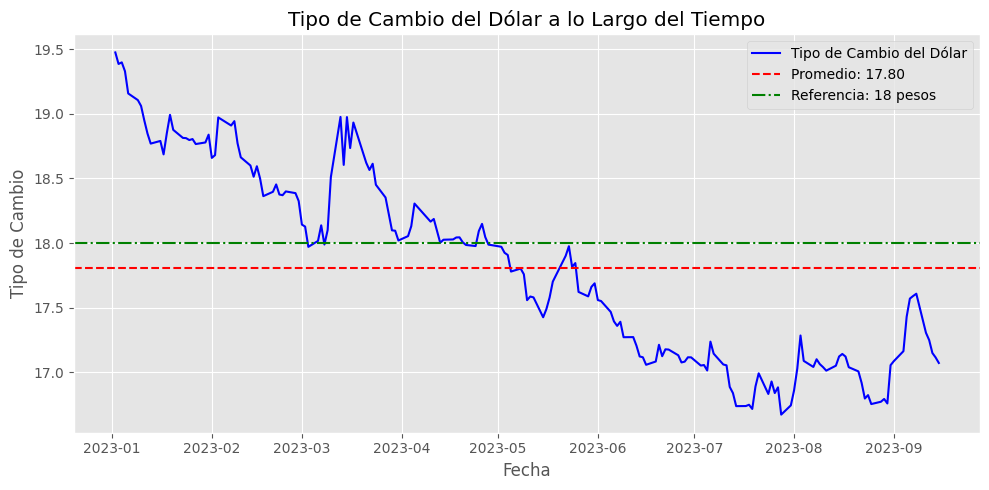

In [65]:
import matplotlib.pyplot as plt

# Asegúrate de que 'fecha' sea de tipo datetime
historico['fecha'] = pd.to_datetime(historico['fecha'])

# Establecer 'fecha' como índice para un mejor manejo en la visualización
historico.set_index('fecha', inplace=True)

# Calcular el promedio
mean_value = historico['dato'].mean()

# Graficar
plt.figure(figsize=(10,5))  # Haciendo la imagen más pequeña
plt.plot(historico['dato'], label='Tipo de Cambio del Dólar', color='blue')
plt.axhline(y=mean_value, color='r', linestyle='--', label=f'Promedio: {mean_value:.2f}')  # Línea de referencia del promedio
plt.axhline(y=18, color='g', linestyle='-.', label='Referencia: 18 pesos')  # Línea de referencia de 18 pesos
plt.title('Tipo de Cambio del Dólar a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Tipo de Cambio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# CONCLUSIÓN

En este Jupyter Notebook, hemos recorrido el proceso de extraer y analizar el histórico del tipo de cambio del peso frente al dólar utilizando la API de Banxico. Las herramientas y técnicas mostradas reflejan la potencia de integrar consultas de APIs y análisis de datos para obtener percepciones esenciales sobre tendencias financieras. Esta combinación nos permite no sólo visualizar la data, sino también interpretarla y entender las fluctuaciones en el contexto económico.



